In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import t


In [2]:
def perform_lagged_analysis(df):
    """Analyzes if current emotions predict next quarter's health metrics."""
    print("\n" + "="*50)
    print("ANALYSIS 2: LAGGED CORRELATION (PREDICTIVE)")
    print("="*50)
    print("This analysis answers: Do emotions in the current quarter predict bug/revert/BIC rates in the NEXT quarter?\n")

    df_lagged = df.copy()
    df_lagged['pBFC_rate_next_quarter'] = df_lagged.groupby('repo')['pBFC_rate'].shift(-1)
    df_lagged['pRevert_rate_next_quarter'] = df_lagged.groupby('repo')['pRevert_rate'].shift(-1)
    df_lagged['pBIC_rate_next_quarter'] = df_lagged.groupby('repo')['pBIC_rate'].shift(-1) # <-- ADDED pBIC_rate lag

    emotion_cols = ['frustration_ratio', 'satisfaction_ratio', 'caution_ratio', 'neutral_ratio']
    lagged_health_cols = ['pBFC_rate_next_quarter', 'pRevert_rate_next_quarter', 'pBIC_rate_next_quarter']
    
    existing_cols = emotion_cols + [col for col in lagged_health_cols if col in df_lagged.columns]
    lagged_corr_matrix = df_lagged[existing_cols].corr()

    existing_lagged_health_cols = [col for col in lagged_health_cols if col in lagged_corr_matrix.columns]
    print("Lagged Correlation Matrix:")
    print(lagged_corr_matrix.loc[emotion_cols, existing_lagged_health_cols])

In [3]:
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import t

def perform_granger_causality(df):
    """Performs Granger Causality tests for each emotion on bug rates."""
    print("\n" + "="*50)
    print("ANALYSIS 3: GRANGER CAUSALITY (RIGOROUS PREDICTIVE TEST)")
    print("="*50)
    print("This analysis answers: Does the history of an emotion's ratio help predict the future of the bug/BIC rate?\n")

    repo_with_most_data = df['repo'].value_counts().idxmax()
    print(f"Performing test on repository with most data points: '{repo_with_most_data}'")
    repo_df = df[df['repo'] == repo_with_most_data].copy()

    emotion_cols = ['frustration_ratio', 'satisfaction_ratio', 'caution_ratio', 'neutral_ratio']
    health_metrics_to_test = ['pRevert_rate', 'pBFC_rate', 'pBIC_rate']

    for health_metric in health_metrics_to_test:
        if health_metric not in repo_df.columns:
            print(f"\nSkipping Granger tests for '{health_metric}': Column not found.")
            continue
        
        for emotion in emotion_cols:
            test_df = repo_df[[emotion, health_metric]].dropna()
            if len(test_df) < 12: # A reasonable minimum for this test
                print(f"\n--- Skipping Granger test for '{emotion}' -> '{health_metric}': Insufficient data ({len(test_df)}) ---")
                continue

            print(f"\n--- Granger Causality Test: Does '{emotion}' predict '{health_metric}'? ---")
            gc_test = grangercausalitytests(test_df[[health_metric, emotion]], maxlag=2, verbose=False)

            # Extracting F-statistic, chi-squared statistic, and p-value for each lag
            for lag in gc_test:
                ssr_ftest = gc_test[lag][0]['ssr_ftest']
                ssr_chi2test = gc_test[lag][0]['ssr_chi2test']
                print(f"Lag {lag}:")
                print(f"  F-statistic: {ssr_ftest[0]:.4f}, p-value: {ssr_ftest[1]:.4f}")
                print(f"  Chi-squared statistic: {ssr_chi2test[0]:.4f}, p-value: {ssr_chi2test[1]:.4f}")

            p_value_lag1 = gc_test[1][0]['ssr_ftest'][1]
            p_value_lag2 = gc_test[2][0]['ssr_ftest'][1]

            if p_value_lag1 < 0.05 or p_value_lag2 < 0.05:
                print(f"Result: SIGNIFICANT. '{emotion}' is a statistically significant predictor of '{health_metric}'.")
            else:
                print(f"Result: NOT SIGNIFICANT. '{emotion}' does not significantly predict '{health_metric}'.")

In [4]:
def get_p_value(r, n):
    """Calculates the p-value for a given Pearson correlation coefficient (r) and sample size (n)."""
    if abs(r) == 1.0:
        return 0.0
    t_statistic = r * ((n - 2) / (1 - r**2))**0.5
    p_value = t.sf(abs(t_statistic), n - 2) * 2
    return p_value

def perform_contemporaneous_analysis(df):
    """Analyzes correlations within the same time period and calculates p-values."""
    print("\n" + "="*50)
    print("ANALYSIS 1: CONTEMPORANEOUS CORRELATION (QUARTERLY)")
    print("="*50)
    print("This analysis answers: What is the immediate relationship between emotions and project health in the same quarter?\n")

    contemporaneous_cols = [
        'frustration_ratio', 'satisfaction_ratio', 'caution_ratio', 'neutral_ratio',
        'avg_commits_per_author',
        'pBFC_rate', 'pRevert_rate', 'pBIC_rate'
    ]
    existing_cols = [col for col in contemporaneous_cols if col in df.columns]
    
    # Calculate correlation and p-value matrices
    corr_matrix = df[existing_cols].corr()
    n = len(df[existing_cols].dropna())
    p_value_matrix = corr_matrix.applymap(lambda r: get_p_value(r, n))

    # Visualize the heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Contemporaneous Correlation Matrix of Emotion and Project Health Metrics')
    plt.tight_layout()
    plt.savefig("quarterly_correlation_heatmap.png")
    plt.show()

    print("\nKey Contemporaneous Correlations (Emotions vs. Health Metrics):")
    emotion_cols = ['frustration_ratio', 'satisfaction_ratio', 'caution_ratio', 'neutral_ratio']
    health_cols = ['pBFC_rate', 'pRevert_rate', 'pBIC_rate', 'avg_commits_per_author']
    existing_health_cols = [col for col in health_cols if col in corr_matrix.columns]
    
    # Display correlation and p-values
    print("Correlation Matrix:")
    print(corr_matrix.loc[existing_health_cols, emotion_cols])
    print("\nP-Value Matrix:")
    print(p_value_matrix.loc[existing_health_cols, emotion_cols])


def perform_repo_level_analysis(df):
    """Aggregates data by repo and analyzes correlations across projects with p-values."""
    print("\n" + "="*50)
    print("ANALYSIS 4: REPOSITORY-LEVEL CORRELATION (AGGREGATED)")
    print("="*50)
    print("This analysis answers: Do repositories with a higher overall emotion ratio also have higher overall bug/BIC/revert rates?\n")

    repo_agg_df = df.groupby('repo').mean().reset_index()

    correlation_cols = [
        'frustration_ratio', 'satisfaction_ratio', 'caution_ratio', 'neutral_ratio',
        'avg_commits_per_author',
        'pBFC_rate', 'pRevert_rate', 'pBIC_rate'
    ]
    existing_cols = [col for col in correlation_cols if col in repo_agg_df.columns]
    
    # Calculate correlation and p-value matrices
    repo_corr_matrix = repo_agg_df[existing_cols].corr()
    n = len(repo_agg_df)
    p_value_matrix = repo_corr_matrix.applymap(lambda r: get_p_value(r, n))


    plt.figure(figsize=(12, 10))
    sns.heatmap(repo_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Repository-Level Correlation Matrix of Emotion and Project Health Metrics')
    plt.tight_layout()
    plt.savefig("repo_level_correlation_heatmap.png")
    plt.show()

    print("\nKey Repository-Level Correlations (Emotions vs. Health Metrics):")
    emotion_cols = ['frustration_ratio', 'satisfaction_ratio', 'caution_ratio', 'neutral_ratio']
    health_cols = ['pBFC_rate', 'pRevert_rate', 'pBIC_rate']
    existing_health_cols = [col for col in health_cols if col in repo_corr_matrix.columns]
    
    # Display correlation and p-values
    print("Correlation Matrix:")
    print(repo_corr_matrix.loc[existing_health_cols, emotion_cols])
    print("\nP-Value Matrix:")
    print(p_value_matrix.loc[existing_health_cols, emotion_cols])

In [5]:
"""Main function to run the entire analysis pipeline."""
print("--- EmoLLM Comprehensive Analysis Pipeline (with pBIC) ---")
df = pd.read_csv("/kaggle/input/emollm/project_health_master.csv")
df['time_period'] = pd.to_datetime(df['time_period'].str.replace('-Q', '-'), format='%Y-%m')
df = df.sort_values(by=['repo', 'time_period'])
print("Master dataset loaded and sorted successfully.")

--- EmoLLM Comprehensive Analysis Pipeline (with pBIC) ---
Master dataset loaded and sorted successfully.


In [6]:
def analyze_churn_correlation(df, level='Quarterly'):
    """
    Performs and visualizes correlation analysis on a given dataframe.
    """
    print(f"\n--- Performing {level} Correlation Analysis for Churn Metrics ---")

    emotion_cols = ['frustration_ratio', 'satisfaction_ratio', 'caution_ratio', 'neutral_ratio']
    churn_cols = ['avg_files_changed', 'avg_lines_added', 'avg_lines_deleted', 'commits_with_churn']
    
    analysis_cols = emotion_cols + churn_cols
    
    # Ensure all columns exist in the dataframe
    existing_cols = [col for col in analysis_cols if col in df.columns]
    if len(existing_cols) != len(analysis_cols):
        print(f"Warning: Some columns are missing for the {level} analysis. Skipping.")
        return

    corr_matrix = df[existing_cols].corr()

    # Visualize the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'{level} Correlation: Emotions vs. Code Churn Metrics (Filtered Data)')
    plt.tight_layout()
    plt.savefig(f"{level.lower()}_churn_correlation_heatmap.png")
    plt.show()

    print(f"\nKey {level} Correlations (Emotions vs. Churn):")
    print(corr_matrix.loc[emotion_cols, churn_cols])


ANALYSIS 1: CONTEMPORANEOUS CORRELATION (QUARTERLY)
This analysis answers: What is the immediate relationship between emotions and project health in the same quarter?



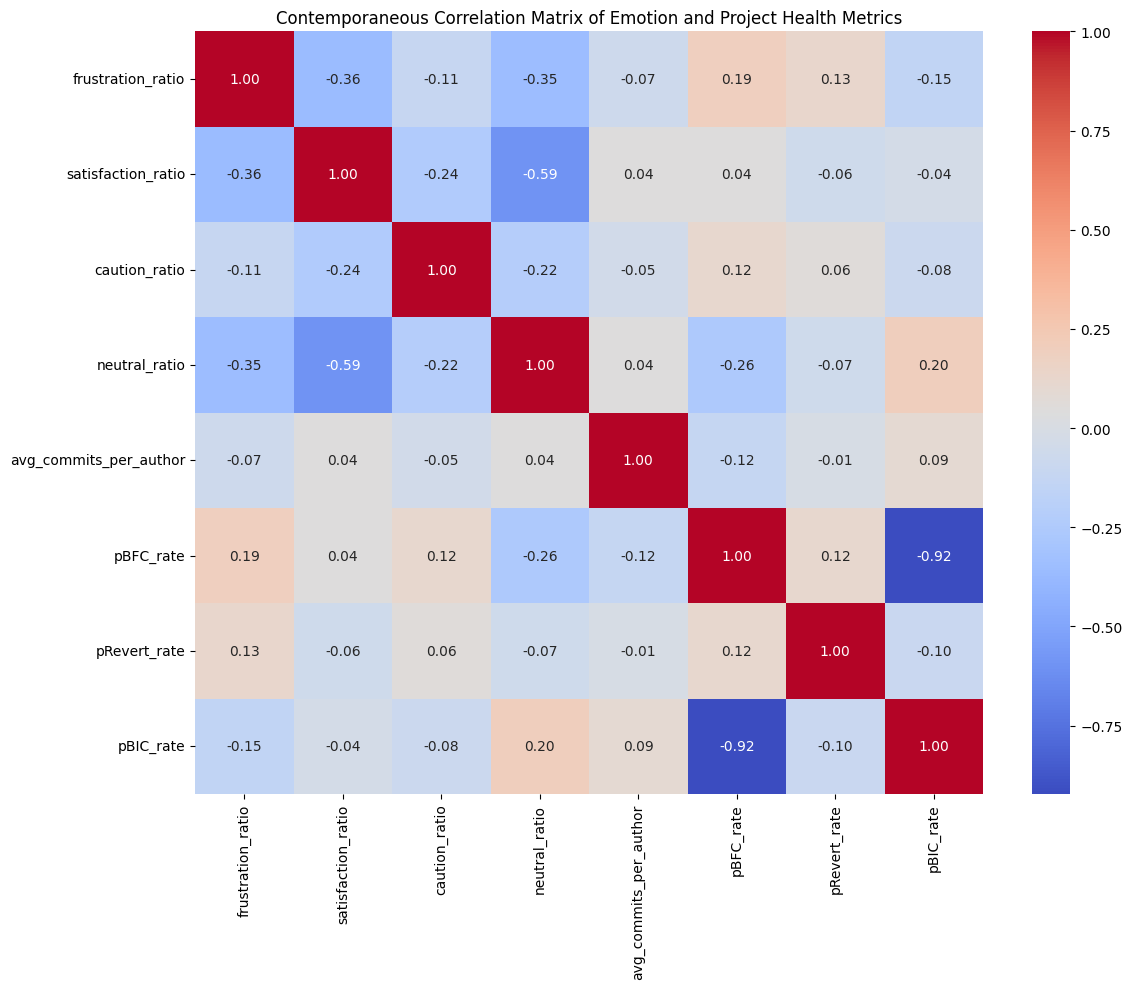


Key Contemporaneous Correlations (Emotions vs. Health Metrics):
Correlation Matrix:
                        frustration_ratio  satisfaction_ratio  caution_ratio  \
pBFC_rate                        0.192981            0.040799       0.117562   
pRevert_rate                     0.127734           -0.064633       0.056200   
pBIC_rate                       -0.148454           -0.035260      -0.081725   
avg_commits_per_author          -0.069165            0.041748      -0.049843   

                        neutral_ratio  
pBFC_rate                   -0.257771  
pRevert_rate                -0.065841  
pBIC_rate                    0.197402  
avg_commits_per_author       0.039551  

P-Value Matrix:
                        frustration_ratio  satisfaction_ratio  caution_ratio  \
pBFC_rate                    2.528251e-15            0.097379       0.000002   
pRevert_rate                 1.897227e-07            0.008595       0.022354   
pBIC_rate                    1.336500e-09            0.15

In [7]:
perform_contemporaneous_analysis(df)

In [8]:
perform_lagged_analysis(df)


ANALYSIS 2: LAGGED CORRELATION (PREDICTIVE)
This analysis answers: Do emotions in the current quarter predict bug/revert/BIC rates in the NEXT quarter?

Lagged Correlation Matrix:
                    pBFC_rate_next_quarter  pRevert_rate_next_quarter  \
frustration_ratio                 0.020061                  -0.008914   
satisfaction_ratio               -0.004351                  -0.014342   
caution_ratio                     0.067967                   0.031279   
neutral_ratio                    -0.048814                   0.004141   

                    pBIC_rate_next_quarter  
frustration_ratio                 0.002448  
satisfaction_ratio                0.002816  
caution_ratio                    -0.073701  
neutral_ratio                     0.035993  


In [9]:
perform_granger_causality(df)


ANALYSIS 3: GRANGER CAUSALITY (RIGOROUS PREDICTIVE TEST)
This analysis answers: Does the history of an emotion's ratio help predict the future of the bug/BIC rate?

Performing test on repository with most data points: 'gcc-mirror/gcc'

--- Granger Causality Test: Does 'frustration_ratio' predict 'pRevert_rate'? ---
Lag 1:
  F-statistic: 0.0564, p-value: 0.8128
  Chi-squared statistic: 0.0578, p-value: 0.8099
Lag 2:
  F-statistic: 0.1348, p-value: 0.8740
  Chi-squared statistic: 0.2818, p-value: 0.8686
Result: NOT SIGNIFICANT. 'frustration_ratio' does not significantly predict 'pRevert_rate'.

--- Granger Causality Test: Does 'satisfaction_ratio' predict 'pRevert_rate'? ---
Lag 1:
  F-statistic: 0.6188, p-value: 0.4331
  Chi-squared statistic: 0.6351, p-value: 0.4255
Lag 2:
  F-statistic: 0.5091, p-value: 0.6025
  Chi-squared statistic: 1.0640, p-value: 0.5874
Result: NOT SIGNIFICANT. 'satisfaction_ratio' does not significantly predict 'pRevert_rate'.

--- Granger Causality Test: Does 


ANALYSIS 4: REPOSITORY-LEVEL CORRELATION (AGGREGATED)
This analysis answers: Do repositories with a higher overall emotion ratio also have higher overall bug/BIC/revert rates?



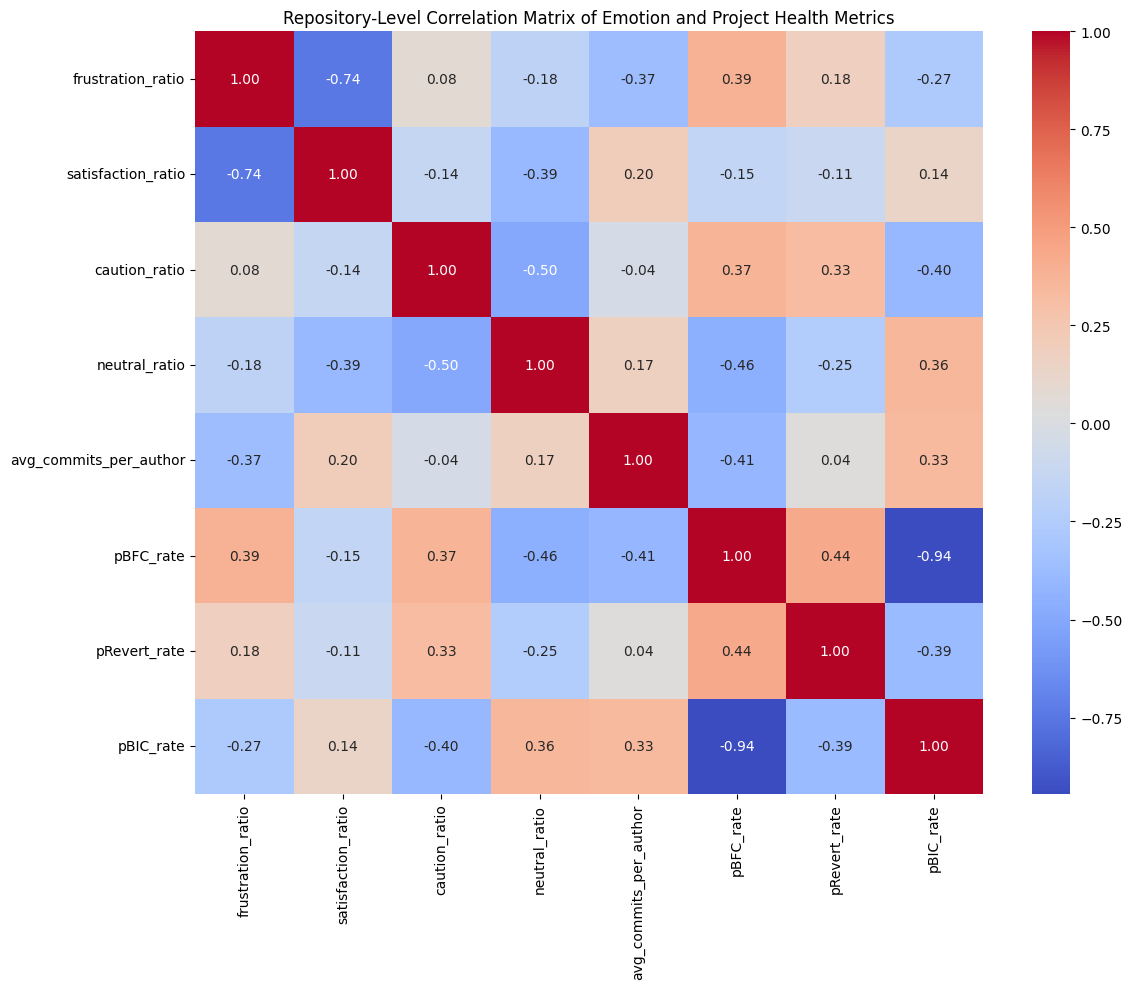


Key Repository-Level Correlations (Emotions vs. Health Metrics):
Correlation Matrix:
              frustration_ratio  satisfaction_ratio  caution_ratio  \
pBFC_rate              0.389667           -0.149200       0.373467   
pRevert_rate           0.182167           -0.112973       0.329842   
pBIC_rate             -0.274111            0.137405      -0.400802   

              neutral_ratio  
pBFC_rate         -0.456094  
pRevert_rate      -0.250372  
pBIC_rate          0.361596  

P-Value Matrix:
              frustration_ratio  satisfaction_ratio  caution_ratio  \
pBFC_rate              0.022725            0.399695       0.029584   
pRevert_rate           0.302477            0.524683       0.056773   
pBIC_rate              0.116703            0.438388       0.018820   

              neutral_ratio  
pBFC_rate          0.006708  
pRevert_rate       0.153244  
pBIC_rate          0.035617  


In [10]:
perform_repo_level_analysis(df)


Filtered dataset to only include rows with churn data.
Original rows: 1652 -> Filtered rows: 327 (19.79%)

--- Performing Quarterly Correlation Analysis for Churn Metrics ---


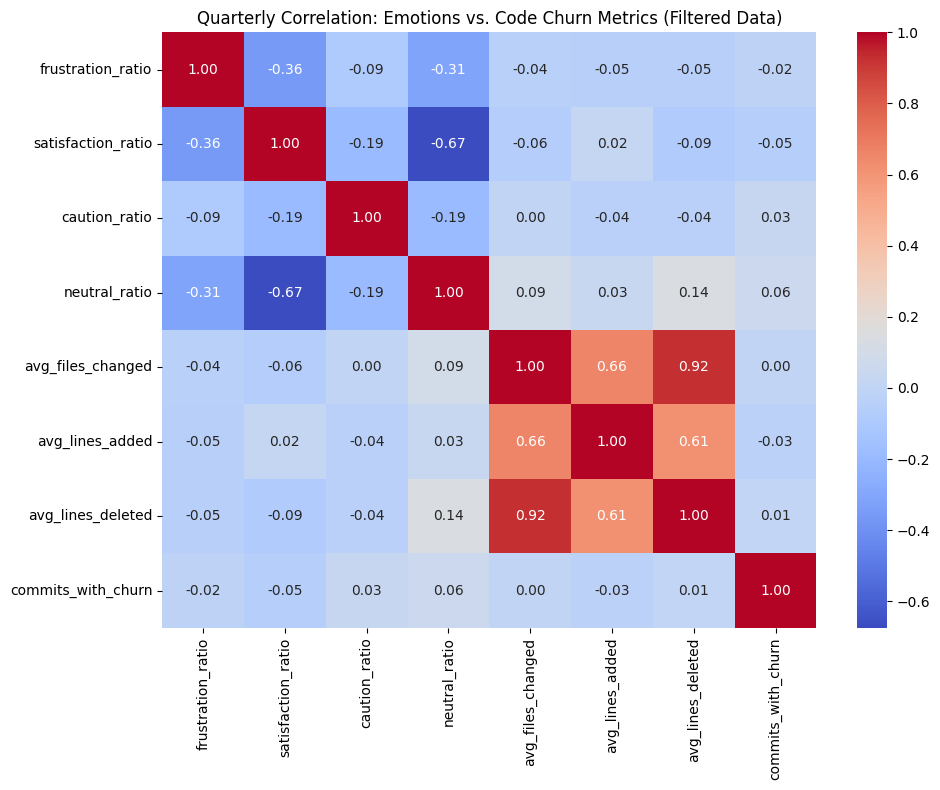


Key Quarterly Correlations (Emotions vs. Churn):
                    avg_files_changed  avg_lines_added  avg_lines_deleted  \
frustration_ratio           -0.041359        -0.051104          -0.047872   
satisfaction_ratio          -0.062699         0.019800          -0.085661   
caution_ratio                0.003517        -0.039563          -0.035995   
neutral_ratio                0.092175         0.034423           0.138229   

                    commits_with_churn  
frustration_ratio            -0.017550  
satisfaction_ratio           -0.053352  
caution_ratio                 0.025623  
neutral_ratio                 0.055499  

--- Performing Repository-Level Correlation Analysis for Churn Metrics ---


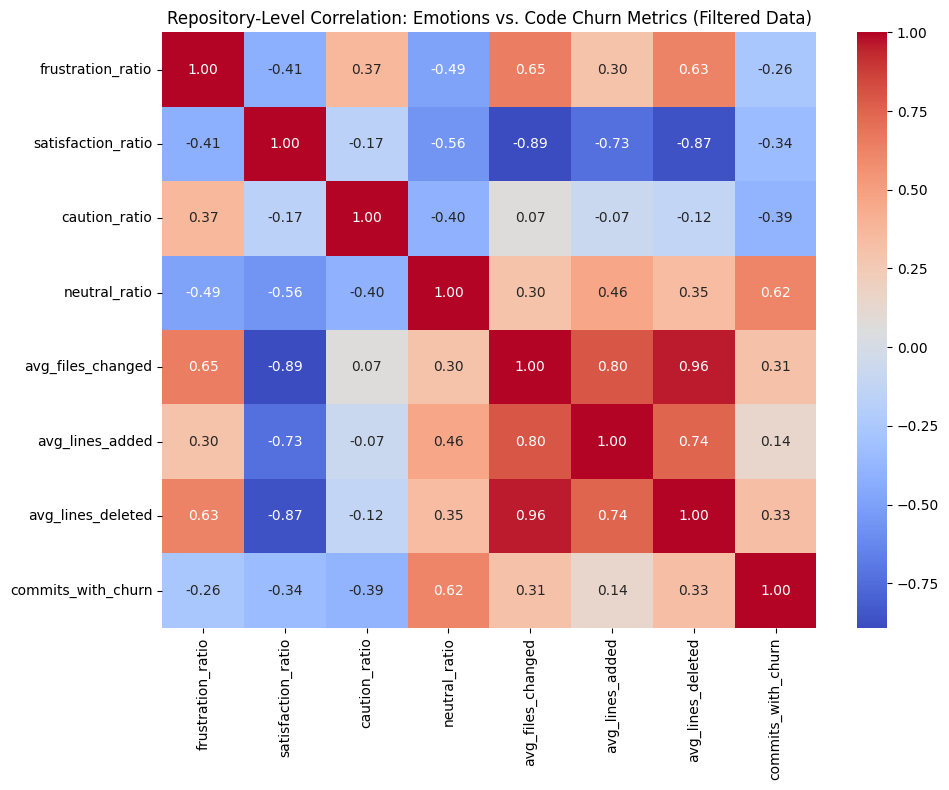


Key Repository-Level Correlations (Emotions vs. Churn):
                    avg_files_changed  avg_lines_added  avg_lines_deleted  \
frustration_ratio            0.651916         0.301598           0.627159   
satisfaction_ratio          -0.891172        -0.734158          -0.867177   
caution_ratio                0.068992        -0.071194          -0.122185   
neutral_ratio                0.300381         0.463011           0.349189   

                    commits_with_churn  
frustration_ratio            -0.257331  
satisfaction_ratio           -0.339744  
caution_ratio                -0.392424  
neutral_ratio                 0.616589  

--- FILTERED CHURN ANALYSIS COMPLETE ---
Generated images: 'quarterly_churn_correlation_heatmap.png' and 'repository-level_churn_correlation_heatmap.png'


In [11]:
"""Main function to run the filtered analysis."""


# --- CRITICAL FILTERING STEP ---
# We only want to analyze data points where churn was actually measured.
# The assumption is that 'commits_with_churn' > 0 indicates valid churn data.
initial_rows = len(df)
df_churn_filtered = df[df['commits_with_churn'] > 0].copy()
filtered_rows = len(df_churn_filtered)

if filtered_rows == 0:
    print("FATAL ERROR: No rows found with 'commits_with_churn' > 0. Cannot perform churn analysis.")
    
    
print(f"\nFiltered dataset to only include rows with churn data.")
print(f"Original rows: {initial_rows} -> Filtered rows: {filtered_rows} ({filtered_rows/initial_rows:.2%})")

# --- 1. QUARTERLY ANALYSIS ON FILTERED DATA ---
analyze_churn_correlation(df_churn_filtered, level='Quarterly')

# --- 2. REPOSITORY-LEVEL ANALYSIS ON FILTERED DATA ---
# First, aggregate the filtered data to the repo level
repo_agg_df = df_churn_filtered.groupby('repo').mean().reset_index()
analyze_churn_correlation(repo_agg_df, level='Repository-Level')

print("\n--- FILTERED CHURN ANALYSIS COMPLETE ---")
print("Generated images: 'quarterly_churn_correlation_heatmap.png' and 'repository-level_churn_correlation_heatmap.png'")
